# Instituto de Educação Superior de Brası́lia – IESB
## Pós-Graduação em Inteligência Artificial
### Reconhecimento de Imagens e Visão Computacional

Atividade 01

Turma: 2021-1

Aluno: Henrique Brandão

[Dataset: https://www.kaggle.com/gpiosenka/100-bird-species](https://www.kaggle.com/gpiosenka/100-bird-species)

___

In [1]:
DIR_DADOS = './dados-birds-species'

In [2]:
!ls -l $DIR_DADOS

total 133168
-rw-rw-r--   1 hbrandao hbrandao      9460 nov  2 18:34  class_dict.csv
-rw-rw-r--   1 hbrandao hbrandao 136289360 nov  2 18:34  EfficientNetB3-birds-98.92.h5
drwxrwxr-x   2 hbrandao hbrandao      4096 nov  9 18:35 'images to test'
drwxrwxr-x   2 hbrandao hbrandao      4096 nov  9 18:35 'one image to test'
drwxrwxr-x 317 hbrandao hbrandao     16384 nov  9 18:35  test
drwxrwxr-x 317 hbrandao hbrandao     16384 nov  9 18:35  train
drwxrwxr-x 317 hbrandao hbrandao     16384 nov  9 18:35  valid


In [3]:
!ls -l $DIR_DADOS/train | wc -l

316


In [4]:
!ls -l $DIR_DADOS/test | wc -l

316


In [5]:
!ls -l $DIR_DADOS/valid | wc -l

316


In [6]:
!head -n 4 $DIR_DADOS/class_dict.csv

In [7]:
!tail -n 4 $DIR_DADOS/class_dict.csv

___

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Sequential
from sklearn.metrics import classification_report
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Softmax
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

%matplotlib notebook

In [9]:
PHYS_DEVICE_NAME = tf.config.list_physical_devices('GPU')[0].name[-5:]
PHYS_DEVICE_NAME

2021-11-09 20:56:24.519607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 20:56:24.539670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 20:56:24.539812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


'GPU:0'

___

In [10]:
BATCH_SIZE = 32

In [11]:
train_ds = image_dataset_from_directory(
    directory=f'{DIR_DADOS}/train',
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

train_ds

Found 45980 files belonging to 315 classes.


2021-11-09 20:56:25.595339: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 20:56:25.595663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 20:56:25.595823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 20:56:25.595940: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<BatchDataset shapes: ((None, 256, 256, 3), (None, 315)), types: (tf.float32, tf.float32)>

In [12]:
H, W, C = 256, 256, 3

In [13]:
train_ds.class_names[::70]

['AFRICAN CROWNED CRANE',
 'CEDAR WAXWING',
 'GREEN MAGPIE',
 'PAINTED BUNTIG',
 'STRIPPED SWALLOW']

In [14]:
_class_names = train_ds.class_names
imgs, labels = [(i, l) for i,l in train_ds.take(1)][0]

2021-11-09 20:56:25.968282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<IPython.core.display.Javascript object>


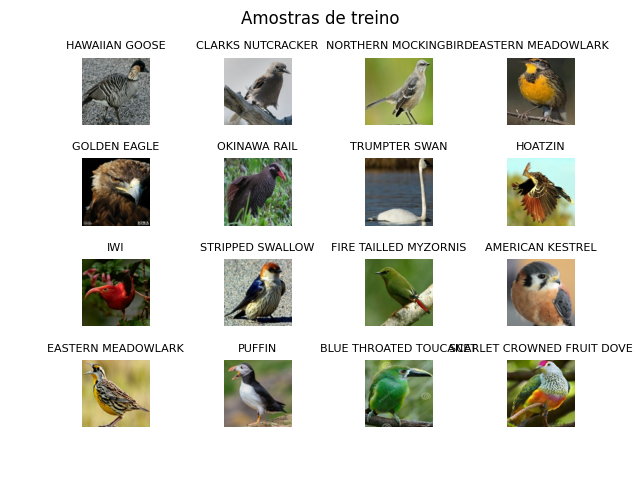

In [15]:
# plt.figure(figsize=(8, 5))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(imgs[i].numpy().astype("uint8"))
    plt.title(label=_class_names[np.argmax(labels[i])], fontdict={'fontsize': 8})
    plt.axis("off")
    i += 1

plt.suptitle('Amostras de treino')
plt.subplots_adjust(wspace=1.0, hspace=0.5)
plt.show()

In [16]:
valid_ds = image_dataset_from_directory(
    directory=f'{DIR_DADOS}/valid',
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

valid_ds

Found 1575 files belonging to 315 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None, 315)), types: (tf.float32, tf.float32)>

In [17]:
test_ds = image_dataset_from_directory(
    directory=f'{DIR_DADOS}/test',
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

test_ds

Found 1575 files belonging to 315 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None, 315)), types: (tf.float32, tf.float32)>

___

In [18]:
es = EarlyStopping(monitor='loss',
                   min_delta=1e-10,
                   patience=5, verbose=1)

mcp = ModelCheckpoint(filepath='birds-clf-weights.h5',
                      save_best_only=True,
                      monitor='loss',
                      verbose=1)

rlp = ReduceLROnPlateau(monitor='val_loss',
                        patience = 1,
                        factor=0.5,
                        verbose=1)

In [19]:
def modelo_clf_passaros():
    clf = Sequential()
    clf.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(H, W, C)) )
    clf.add(MaxPool2D())
    clf.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    clf.add(MaxPool2D())
    clf.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', strides=(2, 2)))
    clf.add(MaxPool2D())
    clf.add(Flatten())
    clf.add(Dense(units=128, activation='relu'))
    clf.add(Dense(units=64, activation='relu'))
    clf.add(Dense(units=32, activation='relu'))
    clf.add(Dense(units=315, activation='softmax'))
    clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics="accuracy")
    print(clf.summary())
    return clf    

In [20]:
clf = modelo_clf_passaros()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0

In [21]:
with tf.device(device_name=PHYS_DEVICE_NAME):
    K.clear_session()
    hist = clf.fit(train_ds, validation_data=valid_ds,
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    callbacks=[es, mcp, rlp])

Epoch 1/10


2021-11-09 20:56:37.009239: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-11-09 20:56:40.255809: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1437/1437 [==============================] - 62s 40ms/step - loss: 5.7955 - accuracy: 0.0113 - val_loss: 5.3605 - val_accuracy: 0.0260

Epoch 00001: loss improved from inf to 5.79545, saving model to birds-clf-weights.h5
Epoch 2/10
1437/1437 [==============================] - 56s 39ms/step - loss: 5.0186 - accuracy: 0.0505 - val_loss: 4.4501 - val_accuracy: 0.0940

Epoch 00002: loss improved from 5.79545 to 5.01861, saving model to birds-clf-weights.h5
Epoch 3/10
1437/1437 [==============================] - 56s 39ms/step - loss: 4.1885 - accuracy: 0.1409 - val_loss: 3.7197 - val_accuracy: 0.1949

Epoch 00003: loss improved from 5.01861 to 4.18851, saving model to birds-clf-weights.h5
Epoch 4/10
1437/1437 [==============================] - 55s 38ms/step - loss: 3.4163 - accuracy: 0.2553 - val_loss: 3.7675 - val_accuracy: 0.2330

Epoch 00004: loss improved from 4.18851 to 3.41626, saving model to birds-clf-weights.h5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00050000002

___

In [36]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

<IPython.core.display.Javascript object>


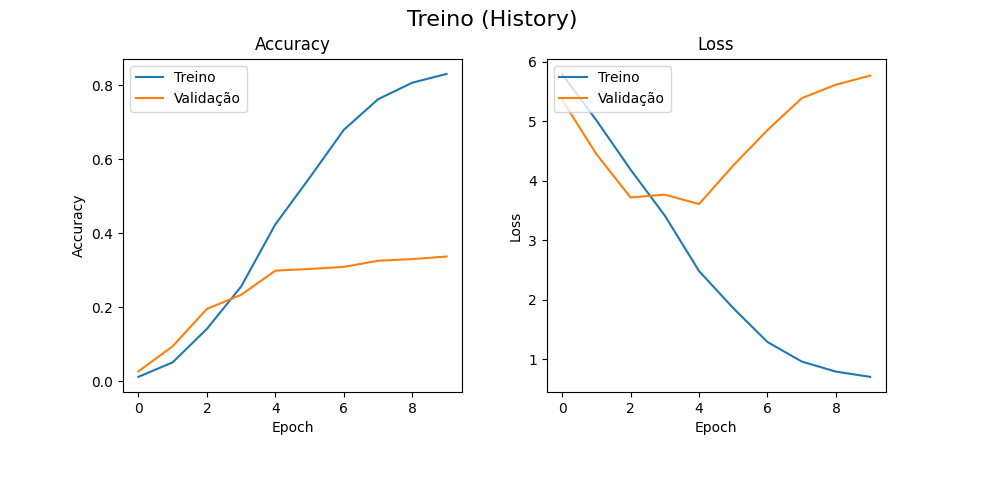

In [49]:
def plot_history(history):
    plt.figure(figsize=(8,4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Treino', 'Validação'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Treino', 'Validação'], loc='upper left')

    plt.suptitle(t='Treino (History)', fontsize=16)
    plt.subplots_adjust(wspace=0.25, hspace=1.0, bottom=0.2)
    plt.show()

plot_history(hist)

___

In [40]:
pred = clf.predict(test_ds)
pred[:5]

array([[5.3000389e-11, 4.0545124e-12, 2.1032891e-08, ..., 2.6719885e-12,
        1.2048306e-27, 6.3924683e-19],
       [6.8382046e-06, 2.3300964e-12, 2.1303952e-02, ..., 4.8103063e-13,
        2.3721997e-16, 1.1685690e-11],
       [6.4835878e-16, 1.9433113e-14, 1.4472613e-04, ..., 3.2155220e-27,
        0.0000000e+00, 4.0312751e-20],
       [7.4964825e-09, 0.0000000e+00, 7.9511497e-26, ..., 0.0000000e+00,
        1.6165777e-24, 3.7401613e-17],
       [6.1712255e-36, 3.0239384e-22, 0.0000000e+00, ..., 2.2423921e-33,
        0.0000000e+00, 3.6003041e-28]], dtype=float32)

In [50]:
LIMIAR = 0.5

In [51]:
pred_argmax = [np.argmax(x) for x in (pred > LIMIAR)]
pred_argmax[:5]

[24, 0, 0, 288, 235]

In [72]:
y = [t for f,t in test_ds.unbatch()]
len(y)

1575

In [73]:
test_argmax = [np.argmax(_) for _ in y]
test_argmax[:5]

[236, 149, 99, 241, 172]

In [76]:
len(test_argmax), len(pred_argmax)

(1575, 1575)

In [78]:
np.sum(np.array(test_argmax) - np.array(pred_argmax))

68175

Justificativa da estrutura da rede e dos hiperparâmetros:

A foram feitos poucos testes com valores distintos, escolhidos através de forma heurística.
Os valores que costam, bem como a estrutura da rede, resultou em um resultado aceitável.
Não achei necessário efetuar buscas semelhantes a _Grid Search_ para estes elementos, haja vista, não são recomendadas, ou encorajadas, para modelos de _deep learning_.
